<a href="https://colab.research.google.com/github/aymanmostafa11/signature-identifiation-and-verification/blob/main/Signature_Verification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# doesn't work for some reason
# import gdown
# gdown.download_folder('https://drive.google.com/drive/folders/1hPuQ7XY90lVnIeJgWzQyuk1WTnZCdgXL?usp=sharing')

In [ ]:
import os
import numpy as np
import pandas as pd
import glob
import random
import cv2
from matplotlib import pyplot as plt

random.seed(42)

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
TRAIN_PATH = '/content/drive/MyDrive/train_test_dataset/train'
TEST_PATH = '/content/drive/MyDrive/train_test_dataset/test'

In [4]:
def read_folders(root_path):
  return glob.glob(root_path + '/*', recursive = True)

### Creating Triplets
Every sample consists of a (anchor, positive, negative) triplet.

In [5]:
def create_triplets(folders_list):

  triplets = []

  for folder in folders_list:
    os.chdir(folder)
    labels_path = [file for file in glob.glob('*.csv')][0]
    labels_dict = pd.read_csv(labels_path, index_col=0, squeeze=True).to_dict()
    forged_list = [dict_item for dict_item in labels_dict if labels_dict[dict_item] == 'forged']
    real_list = [dict_item for dict_item in labels_dict if labels_dict[dict_item] == 'real']
    
    for i in range(len(real_list)):
      for j in range(len(real_list)):
        if i==j:
          continue
        anchor = real_list[i]
        positive = real_list[j]
        for negative in forged_list:
          triplets.append([folder, (anchor, positive, negative)])

  random.shuffle(triplets)
  
  return triplets

In [6]:
train_triplets = create_triplets(read_folders(TRAIN_PATH))

In [7]:
print(len(train_triplets))
images = []
for i in range(5):
  folder, (a, p, n) = train_triplets[i]
  images.append([folder, a, p, n])
  print(train_triplets[i])

38000
['/content/drive/MyDrive/train_test_dataset/train/personE', ('personE_47.png', 'personE_1.png', 'personE_39.png')]
['/content/drive/MyDrive/train_test_dataset/train/personD', ('personD_48.png', 'personD_36.png', 'personD_11.png')]
['/content/drive/MyDrive/train_test_dataset/train/personD', ('personD_39.png', 'personD_20.png', 'personD_4.png')]
['/content/drive/MyDrive/train_test_dataset/train/personD', ('personD_46.png', 'personD_20.png', 'personD_10.png')]
['/content/drive/MyDrive/train_test_dataset/train/personC', ('personC_45.png', 'personC_5.png', 'personC_36.png')]


### Visualizing The Data

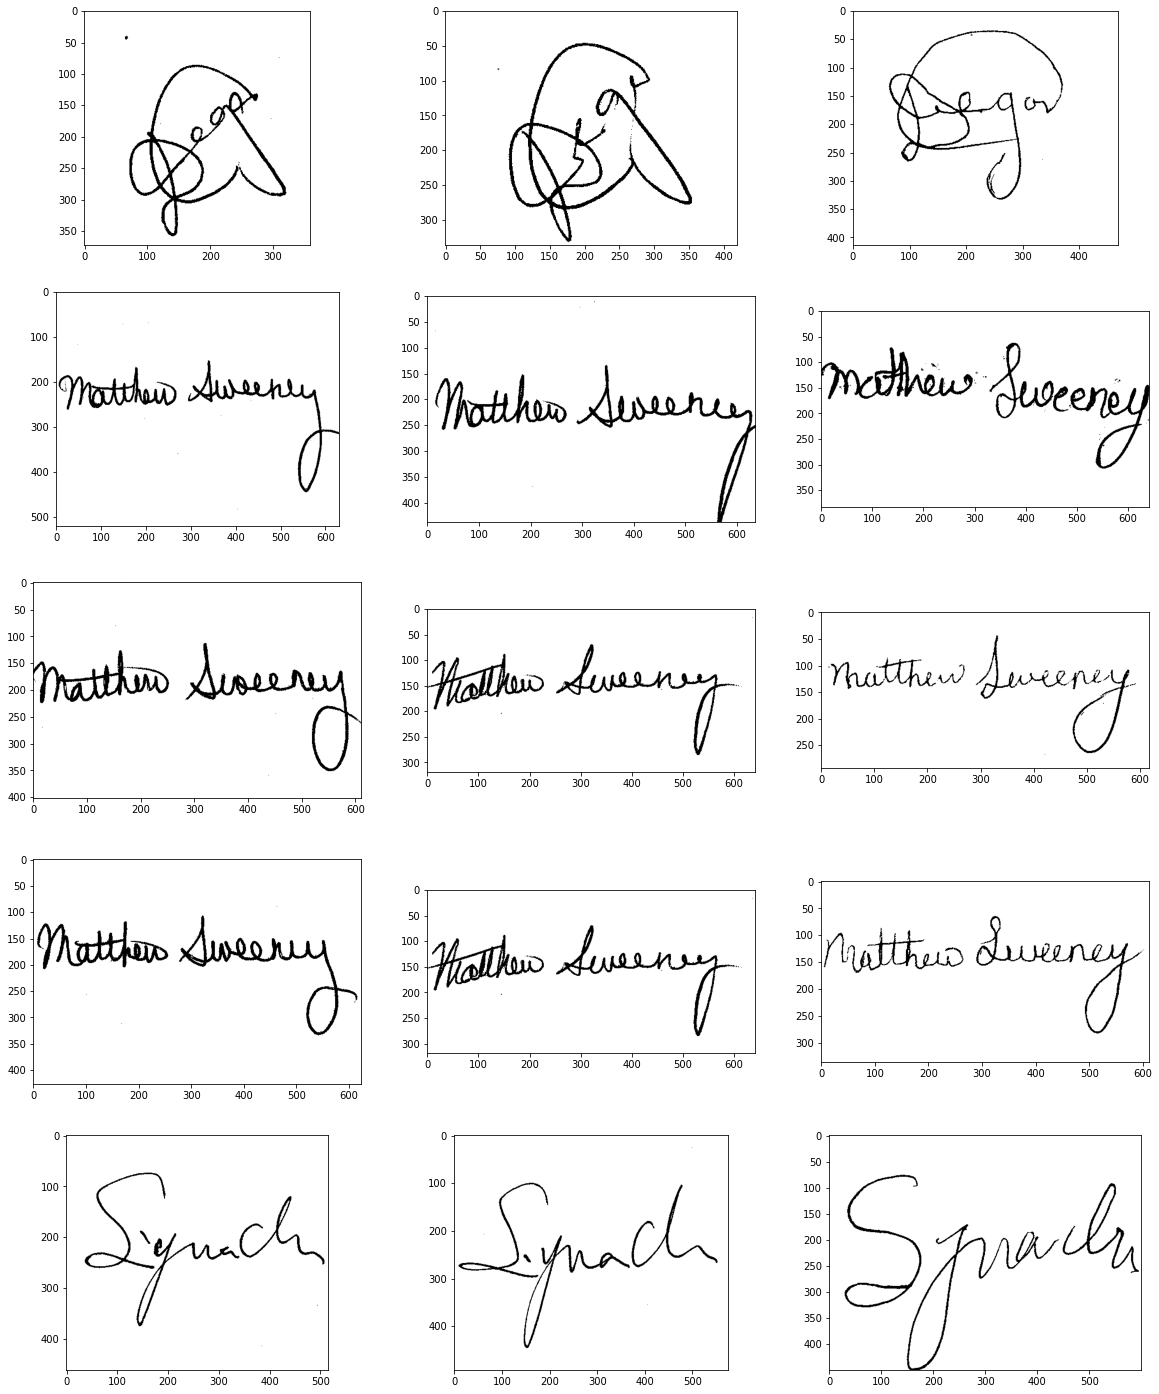

In [8]:
rows = 5
cols = 3

fig, axes = plt.subplots(rows, cols, figsize=(20, 25))

for i in range(rows):
  axes[i, 0].imshow(plt.imread(images[i][0]+'/'+images[i][1]))
  axes[i, 1].imshow(plt.imread(images[i][0]+'/'+images[i][2]))
  axes[i, 2].imshow(plt.imread(images[i][0]+'/'+images[i][3]))


In [9]:
def read_image(image_name, folder_path):
  path = os.path.join(folder_path, image_name)
  image = cv2.imread(path, 0)
  return image

In [10]:
def batch_generator(triplets, batch_size = 256):

  num_of_batches = len(triplets)//batch_size

  for i in range(num_of_batches):
    batch = []
    for j in range(i*batch_size, i*(batch_size+1)):
      folder, (a, p, n) = triplets[j]
      a = read_image(a, folder)
      p = read_image(p, folder)
      n = read_image(n, folder)
      batch.append([a,p,n])
    yield batch

In [12]:
from tensorflow.keras import backend, layers, metrics
import tensorflow as tf
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.applications import Xception
from tensorflow.keras.models import Model, Sequential

In [13]:
def get_encoder(input_shape):
   """ Returns the image encoding model """

   pretrained_model = Xception(
        input_shape=input_shape,
        weights='imagenet',
        include_top=False,
        pooling='avg',
   )

   for i in range(len(pretrained_model.layers)-27):
        pretrained_model.layers[i].trainable = False


   encode_model = Sequential([
        pretrained_model,
        layers.Flatten(),
        layers.Dense(512, activation='relu'),
        layers.BatchNormalization(),
        layers.Dense(256, activation="relu"),
        layers.Lambda(lambda x: tf.math.l2_normalize(x, axis=1))
    ], name="Encode_Model")
  
  
   return encode_model

In [15]:
class distance_layer(layers.Layer):
  # A layer to compute ‖f(A) - f(P)‖² and ‖f(A) - f(N)‖²

  def __init__(self, **kwargs):
    super().__init__(**kwargs)

  def call(self, anchor, positive, negative):
    anchor_positive_distance = tf.reduce_sum(tf.square(anchor - positive), -1)
    anchor_negative_distance = tf.reduce_sum(tf.square(anchor - negative), -1) 

    return (anchor_positive_distance, anchor_negative_distance)

In [18]:
def get_siamese_network(input_shape = (256, 256, 3)):
  encoder = get_encoder(input_shape)

  # Input Layers for the images
  anchor_input = layers.Input(input_shape, name = "Anchor_Input")
  positive_input = layers.Input(input_shape, name = "Positive_Input")
  negative_input = layers.Input(input_shape, name = "Negative_Input")


  # Generate the encodings (feature vectors) for the images
  encoded_anchor = encoder(anchor_input)
  encoded_positive = encoder(positive_input)
  encoded_negative = encoder(negative_input)

  # A layer to compute ‖f(A) - f(P)‖² and ‖f(A) - f(N)‖²
  distances = distance_layer()(
      encoder(anchor_input),
      encoder(positive_input),
      encoder(negative_input)
  )
  
  # Creating the Model
  siamese_network = Model(
    inputs  = [anchor_input, positive_input, negative_input],
    outputs = distances,
    name = "Siamese_Network"
    )

  return siamese_network


In [19]:
siamese_network = get_siamese_network()
siamese_network.summary()

83683744/83683744 [==============================] - 1s 0us/step
Model: "Siamese_Network"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 Anchor_Input (InputLayer)      [(None, 256, 256, 3  0           []                               
                                )]                                                                
                                                                                                  
 Positive_Input (InputLayer)    [(None, 256, 256, 3  0           []                               
                                )]                                                                
                                                                                                  
 Negative_Input (InputLayer)    [(None, 256, 256, 3  0           []                               
                   

In [20]:
class SiameseModel(Model):
  # Builds a Siamese model based on a base-model
  def __init__(self, siamese_network, margin=1.0):
        super(SiameseModel, self).__init__()
        
        self.margin = margin
        self.siamese_network = siamese_network
        self.loss_tracker = metrics.Mean(name="loss")

  def call(self, inputs):
        return self.siamese_network(inputs)

  def train_step(self, data):
    # GradientTape get the gradients when we compute loss, and uses them to update the weights   
    with tf.GradientTape() as tape:
      loss = self._compute_loss(data)

    gradients = tape.gradient(loss, self.siamese_network.trainable_weights)
    self.optimizer.apply_gradients(zip(gradients, self.siamese_network.trainable_weights))  

    self.loss_tracker.update_state(loss)
    return {"loss": self.loss_tracker.result()}


  def test_step(self, data):
        loss = self._compute_loss(data)
        
        self.loss_tracker.update_state(loss)
        return {"loss": self.loss_tracker.result()}


  def _compute_loss(self, data):
        anchor_positive_distance, anchor_negative_distance = self.siamese_network(data)
        loss = tf.maximum(anchor_positive_distance -  anchor_negative_distance + self.margin, 0.0)

        return loss      
 
  @property
  def metrics(self):
    # We need to list our metrics so the reset_states() can be called automatically
    return[self.loss_tracker]      

In [21]:
siamese_model = SiameseModel(siamese_network)
optimizer = Adam(learning_rate = 1e-3, epsilon = 1e-01)
siamese_model.compile(optimizer = optimizer)